# Supervised Learning Methods for Exoplanet Retrieval Models

**SK-Learn Score:** Coefficient of Determination

$$R^2 = \left( 1 - \frac{u}{v} \right)$$

where

$u = \sum_{ij} (y_{true,ij} - y_{pred,ij} )^2$ and $v = \sum_{ij} (y_{true,ij} - \frac{1}{N} \sum_{i} y_{true,ij} )^2$ with $N$ the number of samples.

## Import Packages and Set Paths

In [1]:
from supervised_utils import *

In [2]:
data_path = 'data/'
plots_path = 'plots/general/'
methods = ['PLS','SV','KNN','RNN','DT','RF','VOTE','STACK','XGB']

## Initialize Data

In [3]:
obs_data      = pd.read_csv(data_path+'all_data.csv').drop('planet_ID', axis=1)
aux_data      = pd.read_csv(data_path+'aux_data.csv').drop('Unnamed: 0',axis=1)
fm_data       = pd.read_csv(data_path+'obs_FM_data.csv').drop('Unnamed: 0',axis=1)
spectra       = np.load(data_path+'taurex_matrix.npy')
ariel_spec    = np.load(data_path+'observed_matrix.npy')

aux_data_numpy = aux_data.to_numpy() # aux_train
fm_data_numpy  = fm_data.to_numpy()  # targets_train
wavelengths    = copy.deepcopy(spectra[0,:,0]) # wavelengths
spectra        = copy.deepcopy(spectra[:,:,1]) # spectra

aux_keys_og = aux_data.keys()
aux_keys = ['(log-) Star Distance (pc)',
           'Stellar Mass $(M_\odot)$',
            'Stellar Radius $(R_\odot)$',
            'Stellar Temperature (K)', 
            '(log-) Planet Mass $(M_J)$',
            '(log-) Orbital Period (days)',
            '(log-) Semi-major Axis (AU)',
            'Planet Radius $(R_J)$', 
            '(log-) Surface Gravity $(m/s^2)$']
fm_keys_og = fm_data.keys()
fm_keys = ['$T$',
           '$X_{H_2O}$', 
           '$X_{CO_2}$', 
           '$X_{CH_4}$', 
           '$X_{CO}$',
           '$X_{NH_3}$']

print('Auxiliary Data Shape: ',aux_data_numpy.shape)
print('Auxiliary Data Keys: ',aux_keys_og)
print('-----------------------------------------------')
print('Forward Model Data Shape: ',fm_data_numpy.shape)
print('Forward Model Data Keys: ',fm_keys_og)
print('-----------------------------------------------')
print('Wavelengths Shape: ',wavelengths.shape)
print('Spectra Shape: ',spectra.shape)

Auxiliary Data Shape:  (105887, 9)
Auxiliary Data Keys:  Index(['star_distance', 'star_mass_kg', 'star_radius_m', 'star_temperature',
       'planet_mass_kg', 'planet_orbital_period', 'planet_distance',
       'planet_radius_m', 'planet_surface_gravity'],
      dtype='object')
-----------------------------------------------
Forward Model Data Shape:  (105887, 6)
Forward Model Data Keys:  Index(['planet_temp', 'H2O_model', 'CO2_model', 'CH4_model', 'CO_model',
       'NH3_model'],
      dtype='object')
-----------------------------------------------
Wavelengths Shape:  (52,)
Spectra Shape:  (105887, 52)


## Data Exploration and Preprocessing

Plot an example spectrum

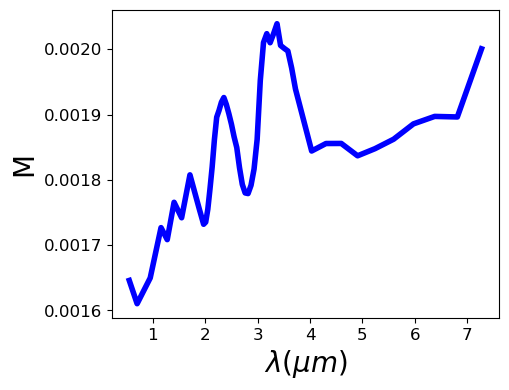

In [4]:
plot_spectra(wavelengths = wavelengths,
             spectra = spectra[0])
# plt.savefig(plots_path+'transmission_spectra_example.png',bbox_inches='tight')

Plot an exmple of a noisy spectrum

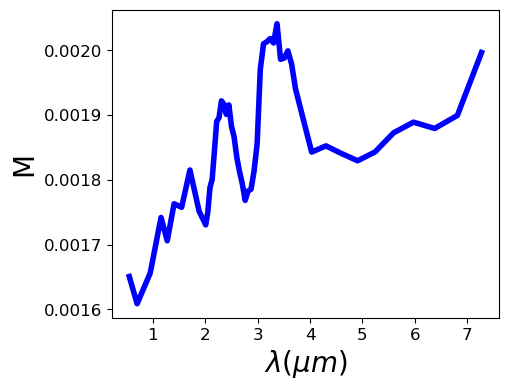

In [5]:
spectra_noise_10ppm = generate_noisy_spectra(spectra = spectra, 
                                             noise_ppm = 10.)
plot_spectra(wavelengths = wavelengths,
             spectra = spectra_noise_10ppm[0])
# plt.savefig(plots_path+'noisy_spectra_example.png',bbox_inches='tight')

Plot the distribution of maximum spectra feature values across all planet instances

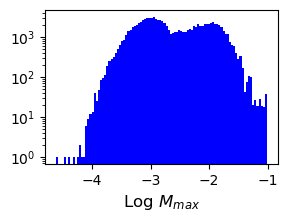

In [6]:
plot_max_spectra_distribution(spectra = spectra)
# plt.savefig(plots_path+'max_spectra.png',bbox_inches='tight')

Plot the distributions of the auxiliary features

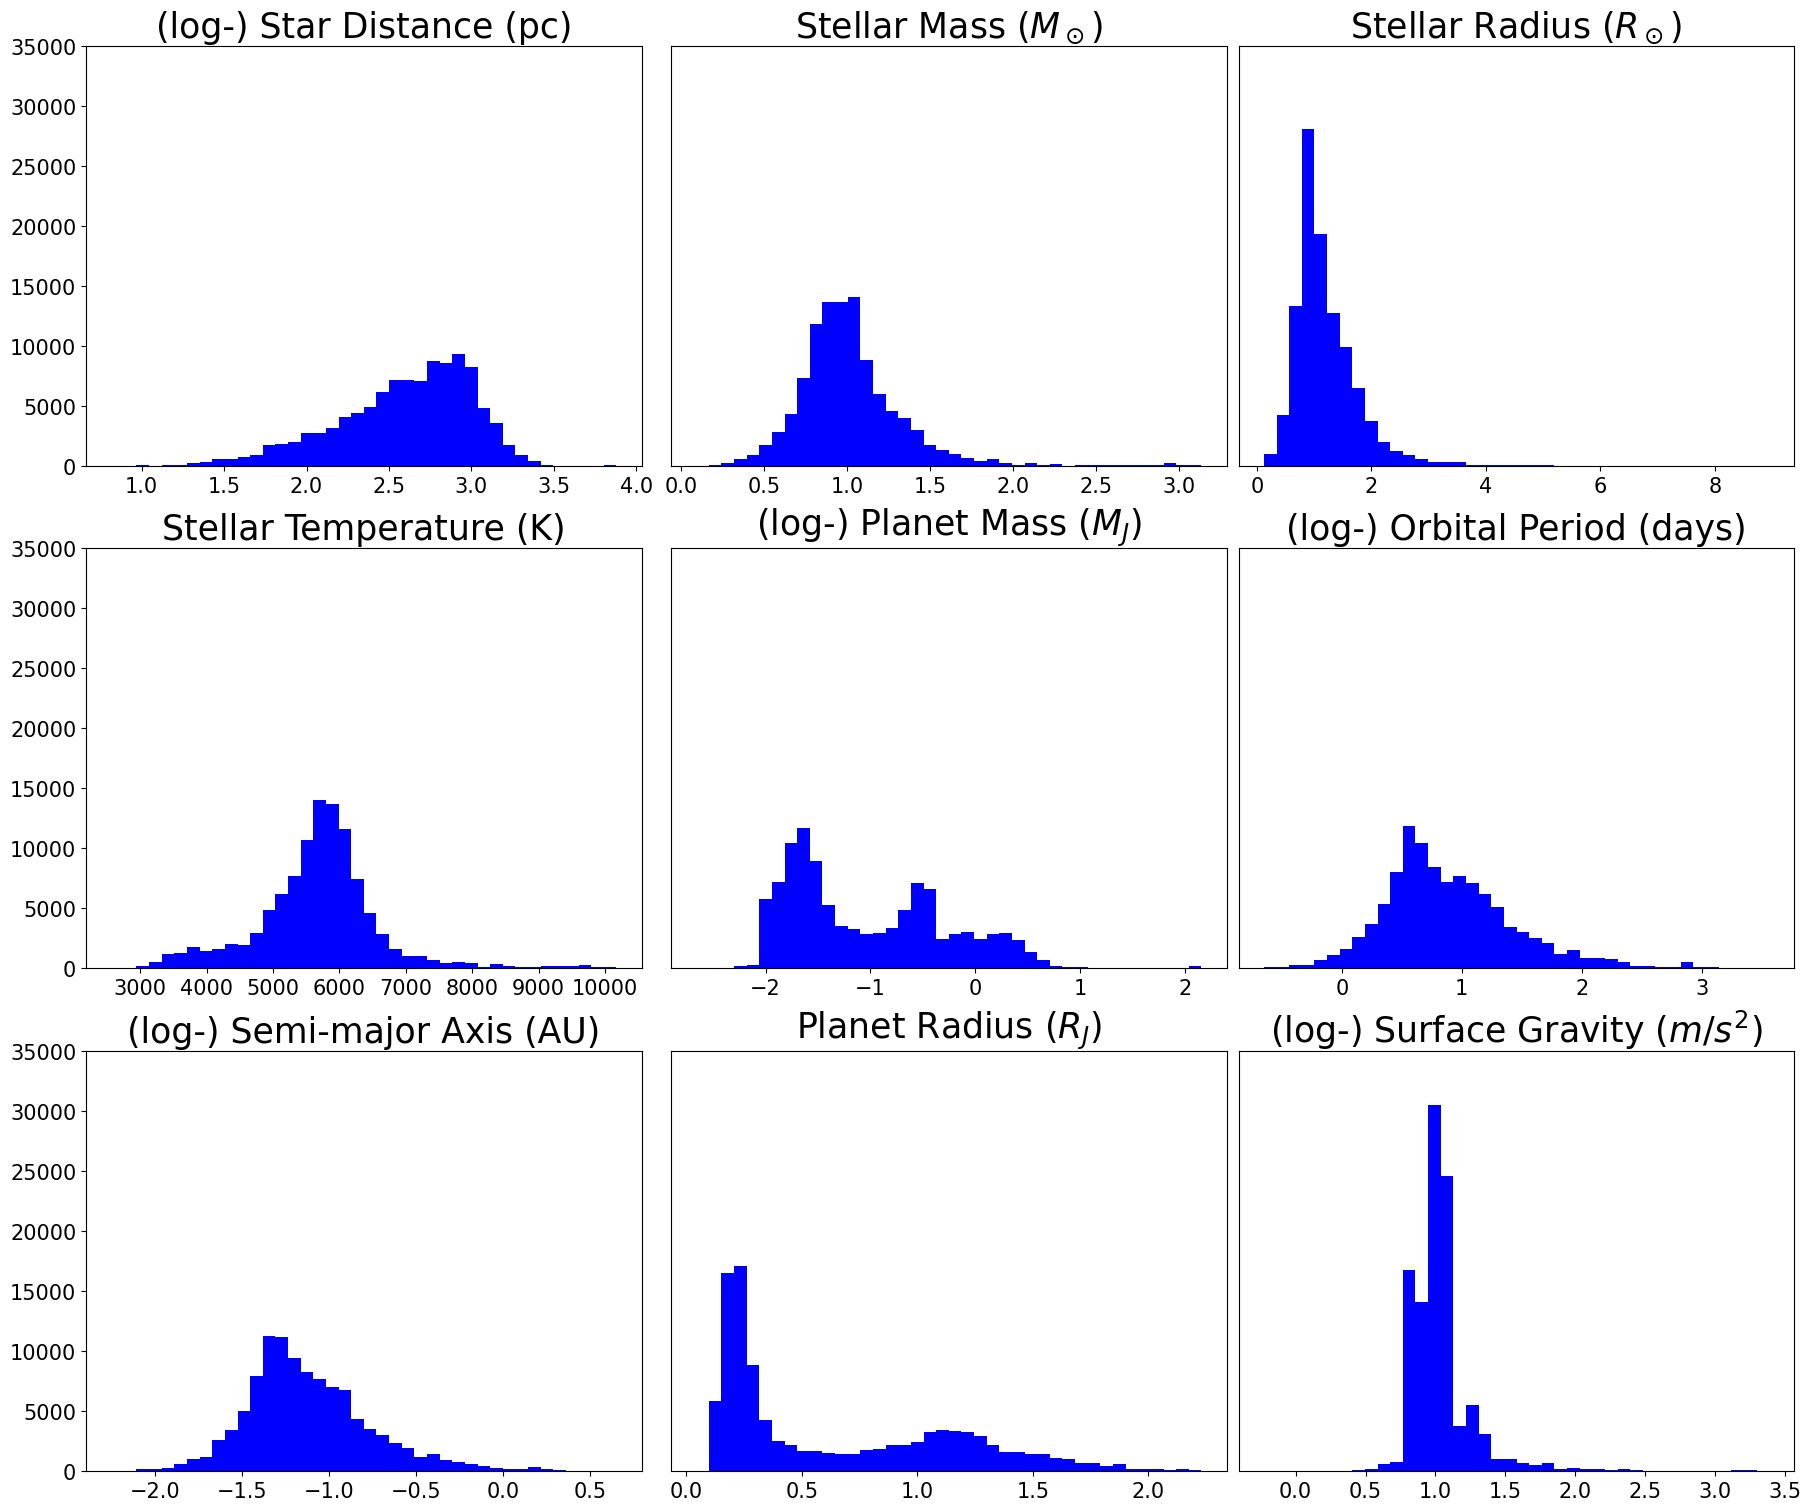

In [7]:
plot_auxiliary_distributions(auxiliary_data  = aux_data_numpy, auxiliary_keys = aux_keys)
# plt.savefig(plots_path+'aux_dist.png',bbox_inches='tight')

Plot the distributions of the forward model (target) parameters

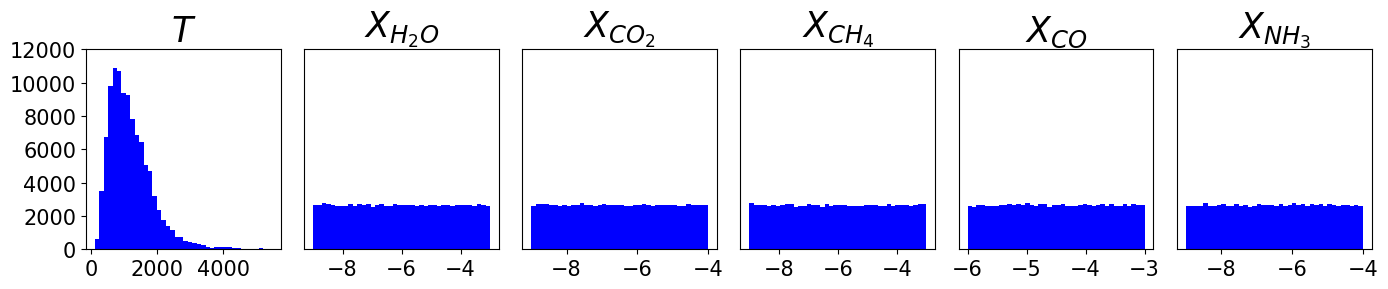

In [8]:
plot_target_distributions(fm_data = fm_data_numpy, fm_keys = fm_keys)
# plt.savefig(plots_path+'fm_dist.png',bbox_inches='tight')

Plot the feature height with respect to the average feature value

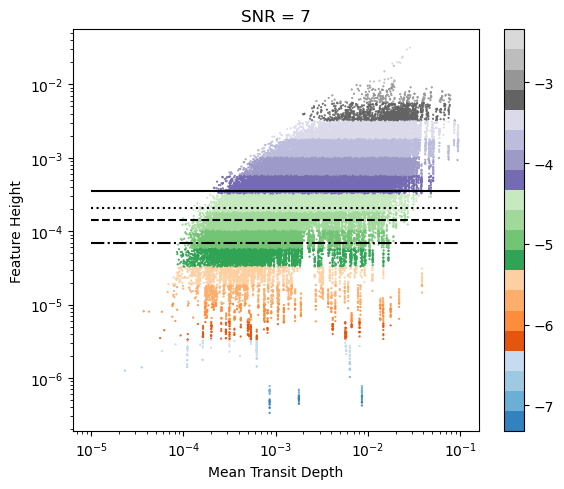

In [9]:
plot_feature_height_vs_mean_transitdepth(spectra)
# plt.savefig(plots_path+'feature_height_mean_transitdepth.png',bbox_inches='tight')

Spectra examples

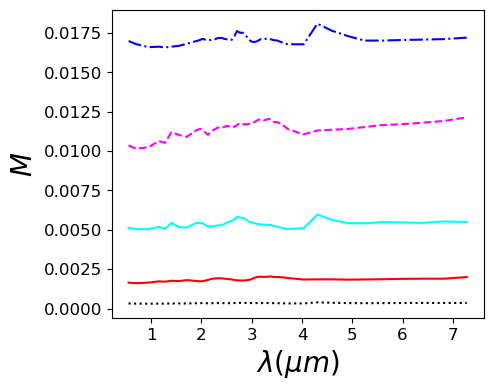

In [10]:
plot_multiple_spectra( wavelengths = wavelengths,
                       spectra = spectra,
                       y_axis_label = '$M$')

Standardization subtracting the mean spectra examples

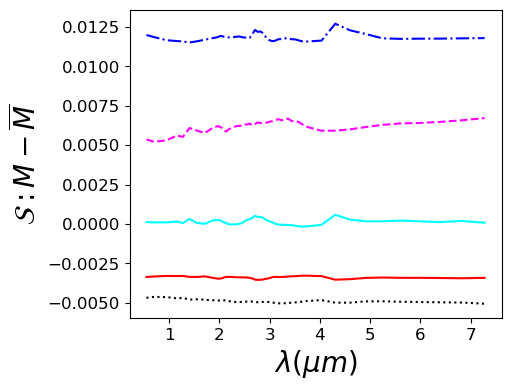

In [11]:
spec_s, spec_s_means, spec_s_std = standardize(spectra)

plot_multiple_spectra( wavelengths = wavelengths,
                       spectra = spectra-spec_s_means,
                       y_axis_label = '$\mathcal{S}: M-\overline{M}$')

Standardized spectra examples

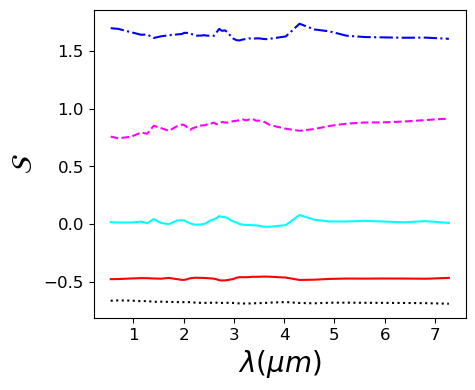

In [12]:
spec_s, spec_s_means, spec_s_std = standardize(spectra)

plot_multiple_spectra( wavelengths = wavelengths,
                       spectra = spec_s,
                       y_axis_label = '$\mathcal{S}$')

Normalization subtracting the mean spectra examples

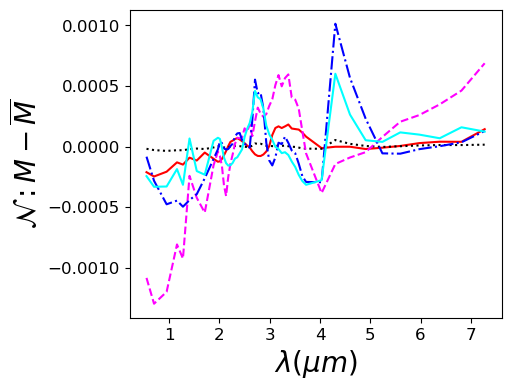

In [13]:
spec_n, spec_n_means, spec_n_std = normalize(spectra)

plot_multiple_spectra( wavelengths = wavelengths,
                       spectra = spectra-spec_n_means[:,None],
                       y_axis_label = '$\mathcal{N}: M-\overline{M}$')

Normalized spectra examples

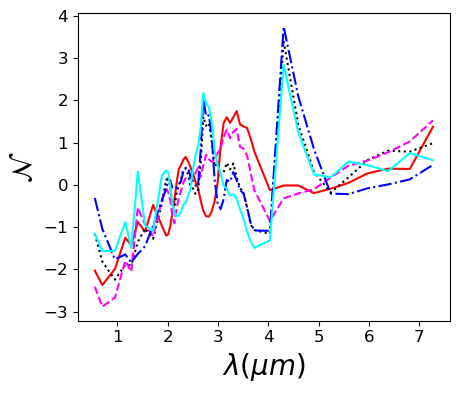

In [14]:
spec_n, spec_n_means, spec_n_std = normalize(spectra)

plot_multiple_spectra( wavelengths = wavelengths,
                       spectra = spec_n,
                       y_axis_label = '$\mathcal{N}$')

Correlation among the original spectra and targets

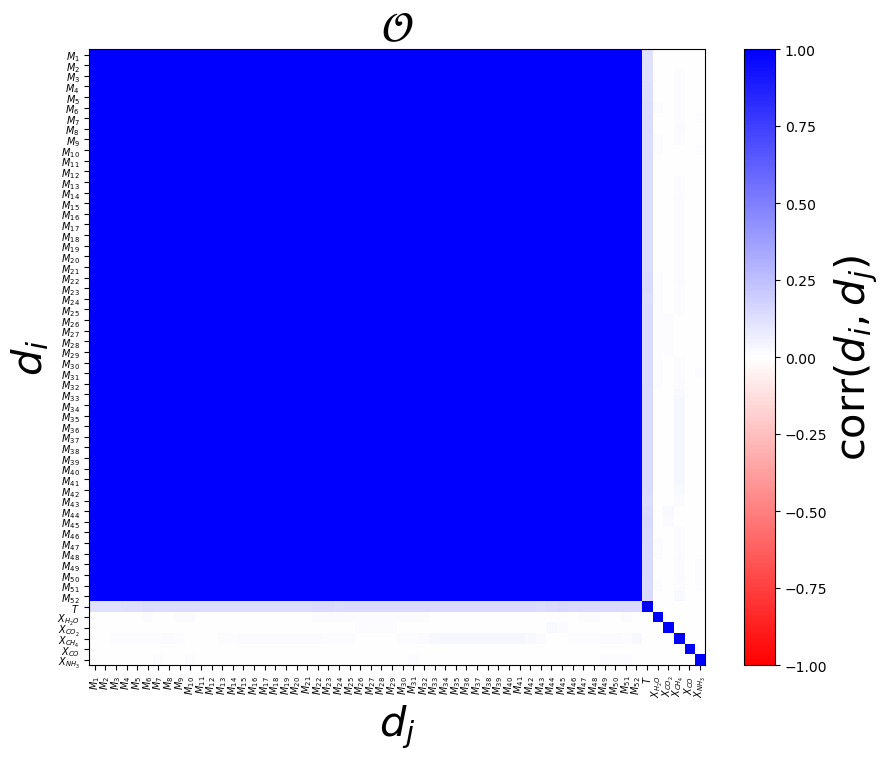

In [15]:
plot_cov_corr_spectra_targets(x = spectra,
                              y = fm_data_numpy,
                              y_keys = fm_keys,
                              title='$\mathcal{O}$',
                              correlation = True,
                              normalize_matrix_entries = False, # Choose none or one of the normalizations, otherwise, entries remain unchanged
                              log_normalize_matrix_entries = False
                              )
# plt.savefig(plots_path+'original_correlation.png',bbox_inches='tight')

Correlation among the first standardizing step in the spectra and targets

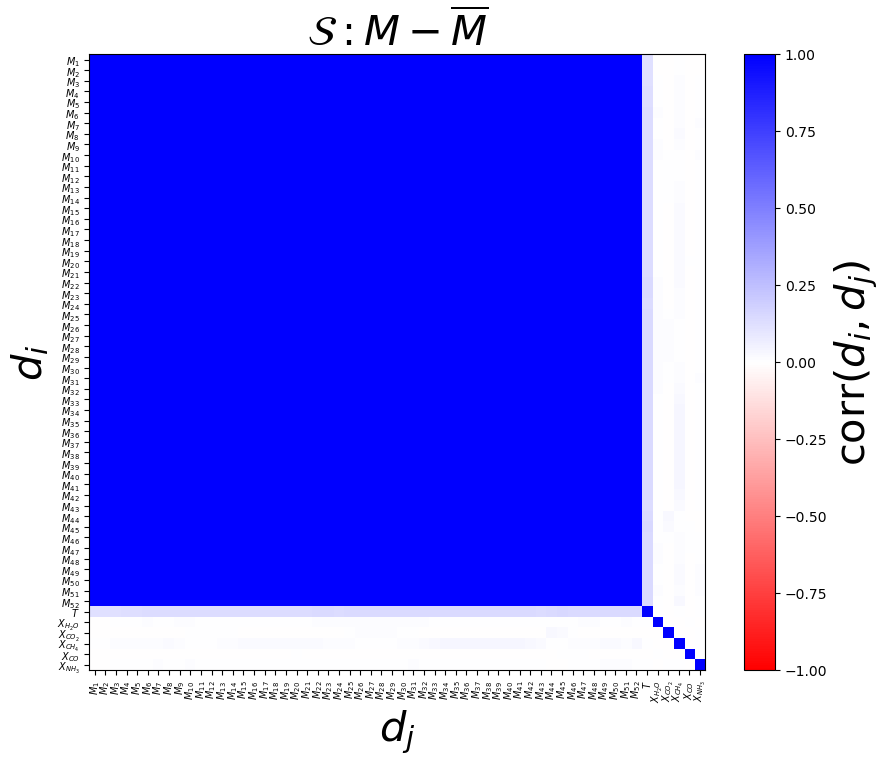

In [16]:
spec_s, spec_s_means, spec_s_std = standardize(spectra)

plot_cov_corr_spectra_targets(x = spectra-spec_s_means,
                              y = fm_data_numpy,
                              y_keys = fm_keys,
                              title='$\mathcal{S}: M-\overline{M}$',
                              correlation = True,
                              normalize_matrix_entries = False, # Choose none or one of the normalizations, otherwise, entries remain unchanged
                              log_normalize_matrix_entries = False
                              )
# plt.savefig(plots_path+'standardsize_firststep_correlation.png',bbox_inches='tight')

Correlation among standardization of the spectra and targets

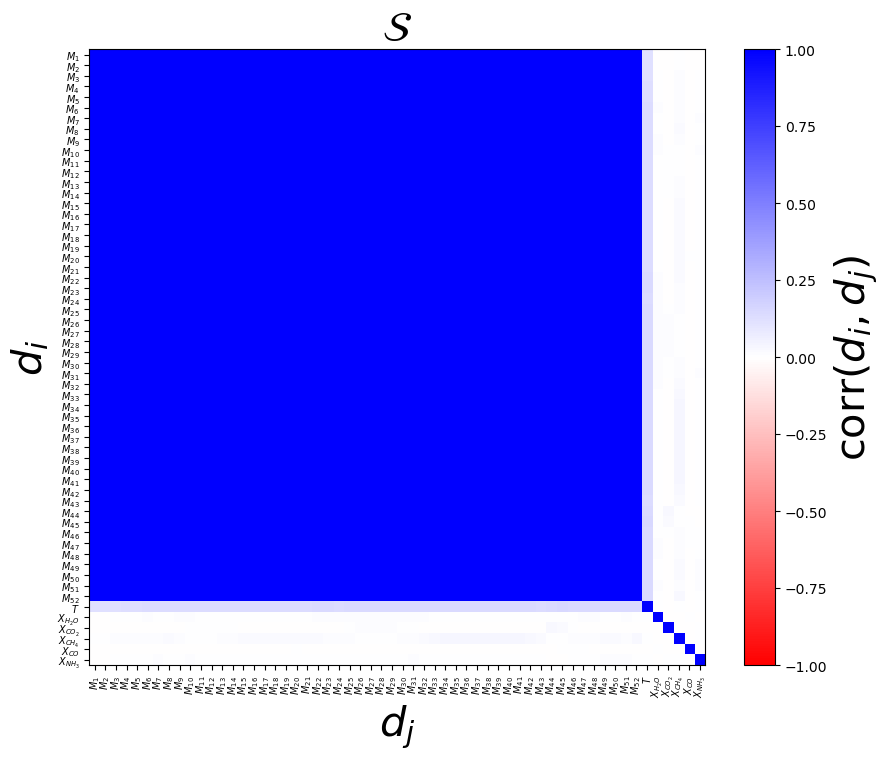

In [17]:
spec_s, spec_s_means, spec_s_std = standardize(spectra)

plot_cov_corr_spectra_targets(x = spec_s,
                              y = fm_data_numpy,
                              y_keys = fm_keys,
                              title='$\mathcal{S}$',
                              correlation = True,
                              normalize_matrix_entries = False, # Choose none or one of the normalizations, otherwise, entries remain unchanged
                              log_normalize_matrix_entries = False
                              )
# plt.savefig(plots_path+'standardsize_correlation.png',bbox_inches='tight')

Correlation among the first normalizing step in the spectra and targets

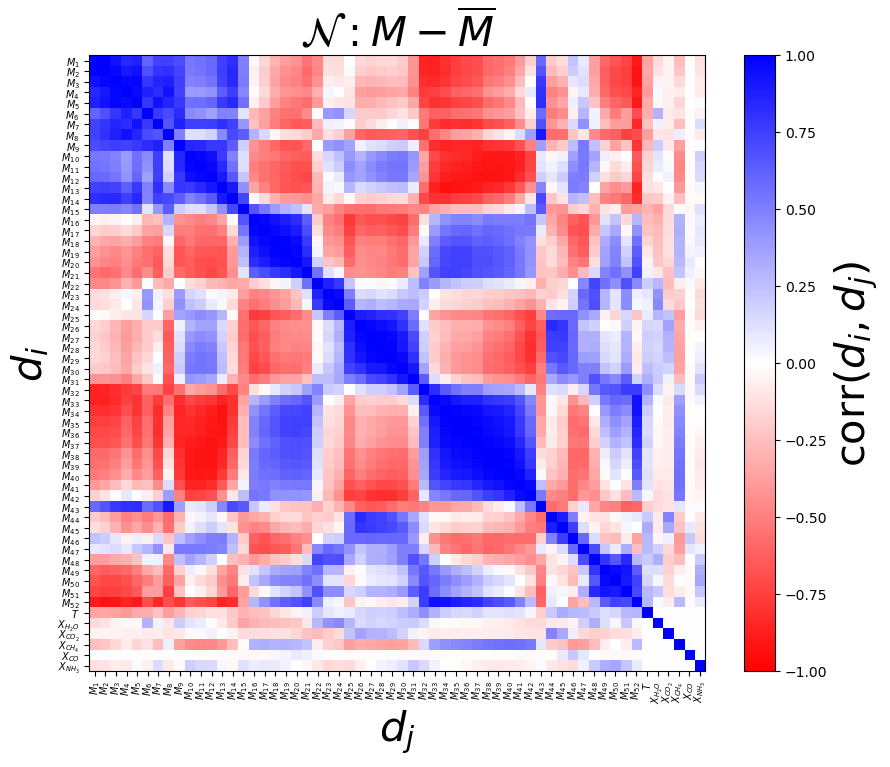

In [18]:
spec_n, spec_n_means, spec_n_std = normalize(spectra)

plot_cov_corr_spectra_targets(x = spectra-spec_n_means[:,None],
                              y = fm_data_numpy,
                              y_keys = fm_keys,
                              title='$\mathcal{N}: M-\overline{M}$',
                              correlation = True,
                              normalize_matrix_entries = False, # Choose none or one of the normalizations, otherwise, entries remain unchanged
                              log_normalize_matrix_entries = False)
# plt.savefig(plots_path+'normalize_firststep_correlation.png',bbox_inches='tight')

Correlation among normalization of the spectra and targets

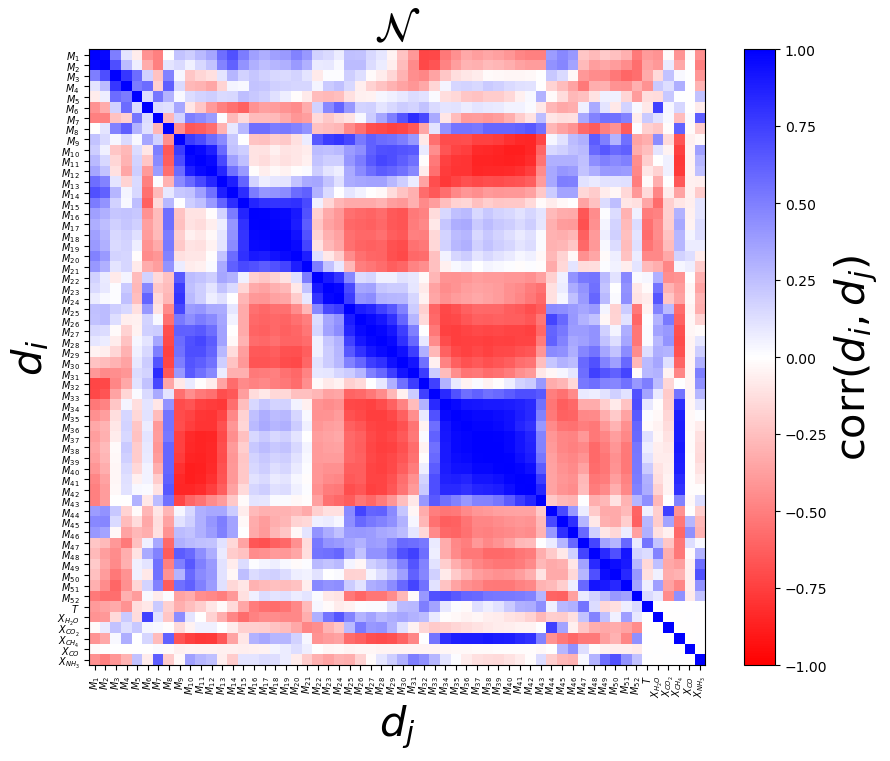

In [19]:
spec_n, spec_n_means, spec_n_std = normalize(spectra)

plot_cov_corr_spectra_targets(x = spec_n,
                              y = fm_data_numpy,
                              y_keys = fm_keys,
                              title='$\mathcal{N}$',
                              correlation = True,
                              normalize_matrix_entries = False, # Choose none or one of the normalizations, otherwise, entries remain unchanged
                              log_normalize_matrix_entries = False
                              )
# plt.savefig(plots_path+'normalize_correlation.png',bbox_inches='tight')

## Transform the Data for Training

**Transform Options**
- 'standardize' (Default)
- 'normalize'

In [20]:
N = 60000
test_percentage = 0.2
noise_spectra_ppm = None
target_ppm_concentrations = False # Use True for ppm concentrations in targets
include_input2 = False # Use True to include the auxiliary data as input
include_input1_mean_std = False # Use True to include mean and std in inputs for normalization of inputs

x_train, x_test, y_train, y_test, y_means, y_stds = transform_data( input1 = spectra,
                                                                    input2 = aux_data_numpy,
                                                                    target = fm_data_numpy,
                                                                    train_test_total_samples = N,
                                                                    train_test_split_test_percentage = test_percentage,
                                                                    train_test_split_random_state = 0,
                                                                    input1_transform = 'standardize',
                                                                    input2_transform = 'standardize',
                                                                    target_transform = 'standardize',
                                                                    noise_ppm = noise_spectra_ppm,
                                                                    target_ppm_concentrations = target_ppm_concentrations,
                                                                    include_input2 = include_input2,
                                                                    include_input1_mean_std = include_input1_mean_std # only applicable for the input transform being normalize
                                                                    )

## Train a Supervised Regression Method

**Supervised Algorithm Keywords**
- Partial Least Squares: 'PLS'
- Support Vector Machine: 'SVM'
- k-Nearest Neighbor: 'KNN'
- r-Nearest Neighbor: 'RNN'
- Decision Tree: 'DT'
- Random Forest: 'RF'
- Voting: 'VOTE'
- Stacking: 'STACK'
- Extreme Gradient Boosting: 'XGB'

Note: Using the SVM, VOTE, and STACK methods could take hours to train on tens of thousands of samples, as they all involve the use of the SVM in our implementation.

Below are the parameters used to obtain the results in the associated publication.

In [21]:
    

param_found_pls = {'n_components': x_train.shape[1], # latent components
                        'max_iter': 500,
                        'scale': True,
                        'tol': 1e-05,
                        'copy': True}
    
param_found_svm= {'C': 5, # regularzation parameter, Good value: 0-10, otheriwse the training becomes long and the model overfits
                'cache_size': 200,
                'coef0': 0,  # only for polynomial and sigmoid kernels
                'degree': 3, # only used for polynomial kernels
                'epsilon': 0.1, #0.1
                'gamma': 0.028, # kernel coefficient
                'kernel': 'rbf', # Gaussian Kernel
                'max_iter': -1,
                'shrinking': True,
                'tol': 0.001,
                'verbose': False}

param_found_knn = {'n_neighbors':6, # nearest neighbors
                'weights':'distance', # neighbors by
                'algorithm':'ball_tree', # optimization method
                'leaf_size':30, # speeds/slows training
                'p':1,  # distance dimension, p=2 is the normal Euclidean distance
                'metric':'minkowski',  # distance metric
                'metric_params':None, 
                'n_jobs':None}

param_found_rnr = {'radius':3, # determines nearest neighbors
                'weights':'distance',  # neighbors by
                'algorithm':'ball_tree', #optimization method
                'leaf_size':30, # speeds/slows training
                'p':2,  # distance dimension, p=2 is the normal Euclidean distance
                'metric':'minkowski',  # distance metric
                'metric_params':None,
                'n_jobs':None}

param_found_dtr = {'criterion':'squared_error', # metric
                'splitter':'random',  # leaf splitter
                'max_depth':None,  # maximum number of lengths from the root node to the bottom of the tree
                'min_samples_split':48, # minimum samples required to split a node
                'min_samples_leaf':13, # minimum samples required to reside at a node after the split
                'min_weight_fraction_leaf':0,
                'random_state':None,
                'max_leaf_nodes':None,
                'min_impurity_decrease':0,
                'ccp_alpha':0.0}

param_found_rfr = {'n_estimators':115,   # number of trees
                'criterion':'squared_error',  # metric
                'max_depth':None,  # maximum number of lengths from the root node to the bottom of the tree
                'min_samples_split':48,  # minimum samples required to split a node
                'min_samples_leaf':13,  # minimum samples required to reside at a node after the split
                'min_weight_fraction_leaf':0,
                'max_features':27,
                'max_leaf_nodes':None,
                'min_impurity_decrease':0,
                'bootstrap':True,
                'oob_score':False,
                'n_jobs':None,
                'random_state':None,
                'verbose':0,
                'warm_start':False,
                'ccp_alpha':0.0,
                'max_samples':None }

param_found_xgb = { #n_estimators=500,
                    # max_depth=3,
                    # learning_rate=1e-1,
                    'random_state':42,
                    'early_stopping_rounds':15
                    #  max_depth= 0,
                #  max_leaves=0,
                # max_bin=256,
                # grow_policy='depthwise',
                # verbosity = 0,
                #  objective,
                # booster='gbtree',
                # tree_method='auto',
                # n_jobs=1,
                # gamma=0,
                # min_child_weight=1,
                #  max_delta_step,
                # subsample=1)
                #  sampling_method,
                #  colsample_bytree=1,
                #  colsample_bytree,
                #  colsample_bylevel,
                #  colsample_bynode,
                #  reg_alpha,
                #  reg_lambda,
                #  scale_pos_weight,
                #  base_score,
                #  random_state,
                #  missing,
                #  num_parallel_tree,
                #  monotone_constraints,
                #  interaction_constraints,
                #  importance_type,
                #  gpu_id,
                #  validate_parameters,
                #  predictor,
                #  enable_categorical,
                #  feature_types,
                #  max_cat_to_onehot,
                #  max_cat_threshold,
                #  eval_metric,
                #  early_stopping_rounds,
                #  callbacks
                    }

### Example 1 of 3: PLS Method

In [22]:
method_string = 'PLS'
single_method_parameters = param_found_pls
ensemble_regressors_list = None # Only for ensemble methods VOTE and STACK
ensemble_regressor_parameters_list = None # Only for ensemble methods VOTE and STACK
final_regressor_string = None  # Only for ensemble method STACK
single_final_regressor_parameters = None

trained_regressor_list, predictions, true_test_targets = supervised_training(x = x_train,
                                                                        y = y_train, 
                                                                        x_test = x_test,
                                                                        y_test = y_test,
                                                                        target_means = y_means,
                                                                        target_stds = y_stds,
                                                                        method = method_string,
                                                                        y_keys = fm_keys,
                                                                        method_parameters = single_method_parameters,
                                                                        ensemble_regressors = ensemble_regressors_list, # SVM, KNN, DT, RF (Voting), SVM, KNN, DT (Stacking) were used in the paper
                                                                        ensemble_regressor_parameters = ensemble_regressor_parameters_list ,
                                                                        final_regressor = final_regressor_string, # RF (Stacking only) were used in the paper
                                                                        final_regressor_parameters = single_final_regressor_parameters,
                                                                        target_transform = 'standardize',
                                                                        target_ppm_concentrations = target_ppm_concentrations
                                                                        )

PLS Accuracy (sklean score):  0.35692337560966275
PLS Training Duration:  4.132638931274414  s
PLS Mean Absolute Error:  0.20252222426363709


Make a scatter plot of the predictions vs. the true values colored by the absolute difference between them

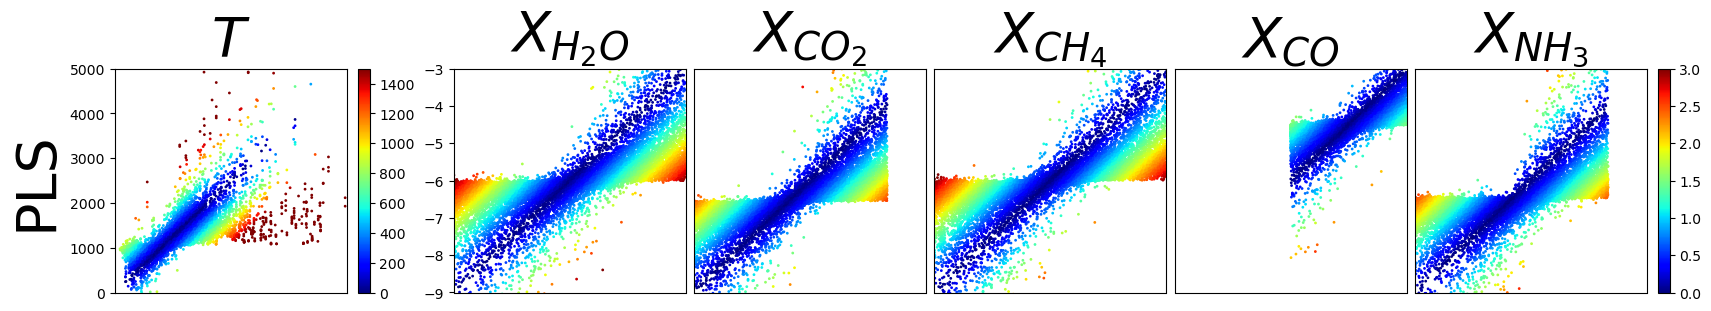

In [23]:
plot_scatter_true_predictions(y_true = true_test_targets,
                              y_pred = predictions,
                              y_keys = fm_keys,
                              method= method_string)

# plt.savefig(plots_path+'standardizelog_pls_scatter.png',bbox_inches='tight')

Plot the histogram of errors between the true and predicted values

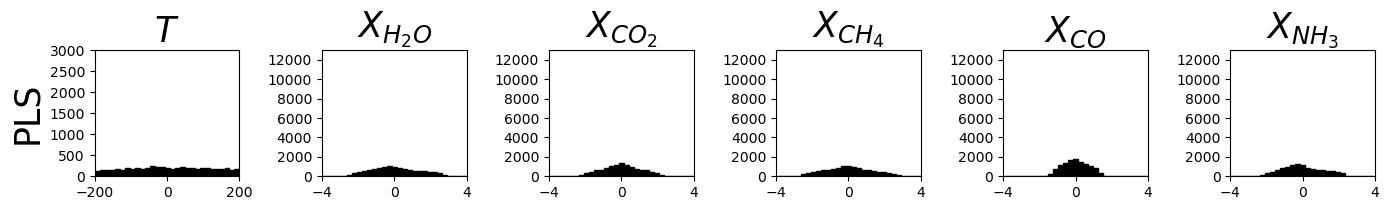

In [24]:
plot_histogram_error( y_true = true_test_targets,
                      y_pred = predictions,
                      y_keys = fm_keys,
                      method = method_string)

# plt.savefig(plots_path+'standardizelog_pls_histerror.png',bbox_inches='tight')

Plot the histogram of errors between the true and predicted values sorted by the maximum target value to the minimum target value

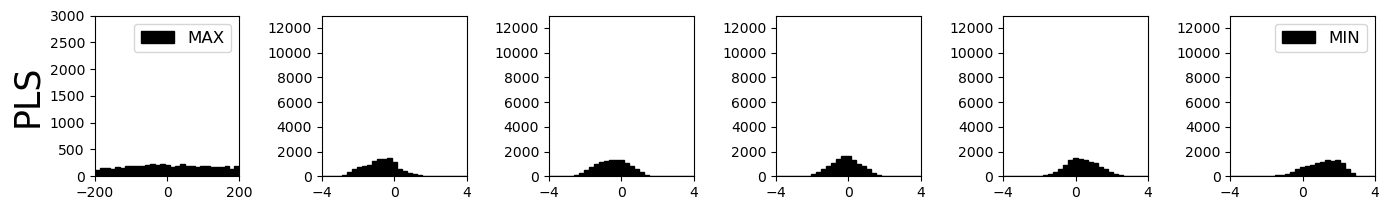

In [25]:
plot_histogram_error_maxmin(y_true = true_test_targets,
                            y_pred = predictions,
                            method = method_string)

# plt.savefig(plots_path+'standardizelog_pls_histerror_maxmin.png',bbox_inches='tight')

Plot a chart of the mean absolute relative error (MARE) for each target and the MARE for the true sample targets sorted from largest to smallest

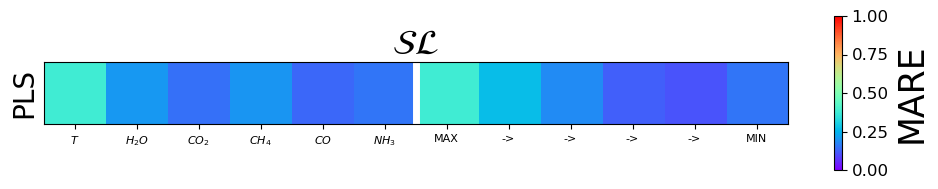

In [26]:
plot_mare_per(y_true = true_test_targets,
              y_pred = predictions,
              y_keys = fm_keys,
              method = method_string,
              title = '$\mathcal{SL}$')

# plt.savefig(plots_path+'standardizelog_pls_mare.png',bbox_inches='tight')

Plot the model bias vs bins based on the true test values

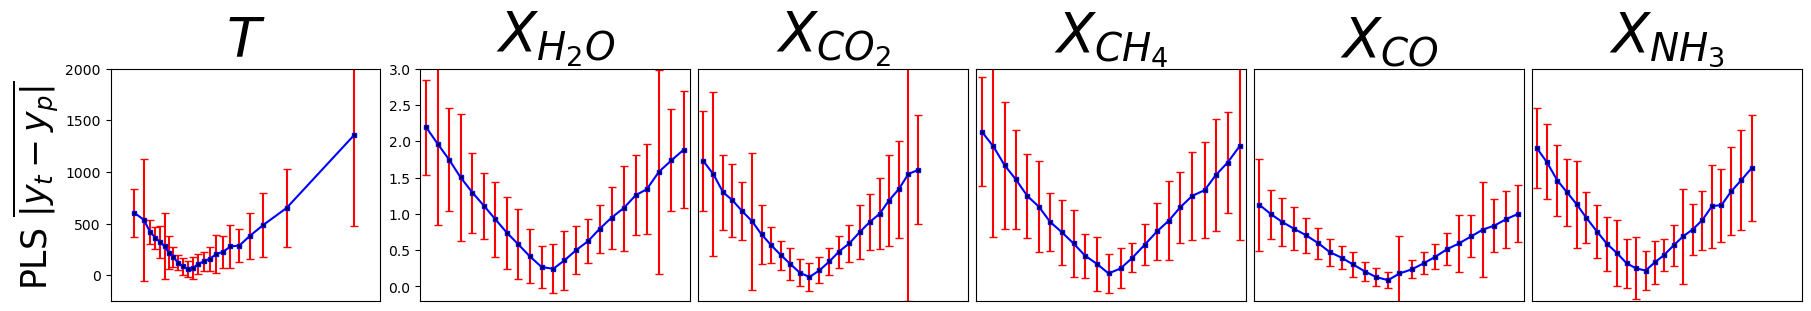

In [27]:
true_bins, avg_truebin_deviation, std_pred_truebins = plot_model_bias_with_ytrue_bins(y_true = true_test_targets,
                                                                                      y_pred = predictions,
                                                                                      y_keys = fm_keys,
                                                                                      y_label_string = method_string+r' $\overline{|y_t-y_p|}$')

# plt.savefig(plots_path+'standardizelog_pls_bias_truebins.png',bbox_inches='tight')

Plot bins of the predicted values vs the average bin error

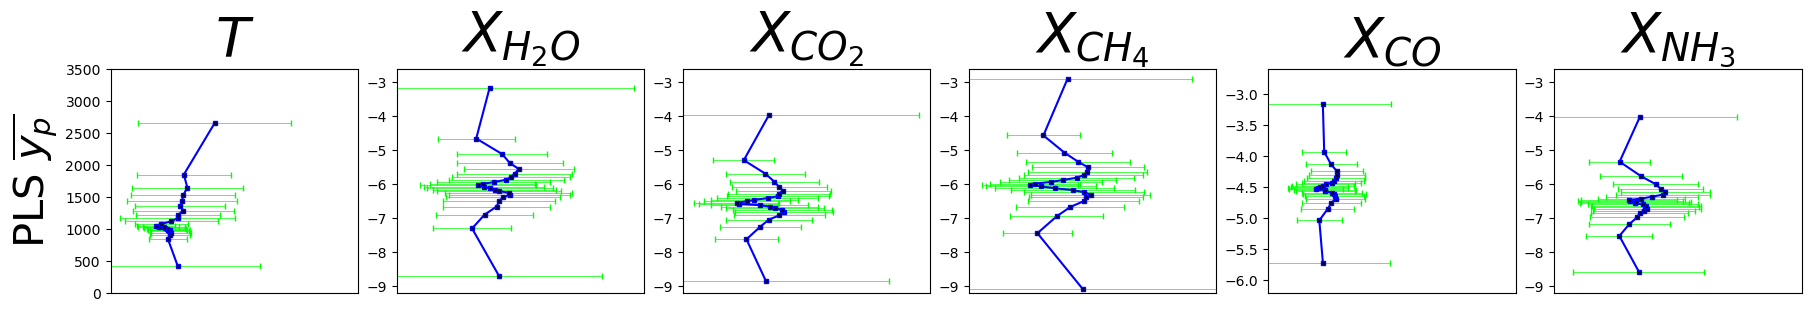

In [28]:
pred_bins, avg_predbin_deviation, std_pred_predbins = plot_ypred_bins_with_average_error(y_true = true_test_targets,
                                                                                         y_pred = predictions,
                                                                                         y_keys = fm_keys,
                                                                                         y_label_string = method_string+r' $\overline{y_p}$')

# plt.savefig(plots_path+'standardizelog_pls_predbins_error.png',bbox_inches='tight')

### Example 2 of 3: Voting Method

Note: sklearn has a shape error in the predictions for PLS in the ensemble scheme. Avoid using PLS in the ensemble until issue is resolved.

In [29]:
method_string = 'VOTE'
single_method_parameters = None
ensemble_regressors_list = ['KNN','DT','RF'] # Only for ensemble methods VOTE and STACK
ensemble_regressor_parameters_list = [param_found_knn, param_found_dtr, param_found_rfr] # Only for ensemble methods VOTE and STACK
final_regressor_string = None  # Only for ensemble method STACK
single_final_regressor_parameters = None

trained_regressor_list, predictions, true_test_targets = supervised_training(x = x_train,
                                                                        y = y_train, 
                                                                        x_test = x_test,
                                                                        y_test = y_test,
                                                                        target_means = y_means,
                                                                        target_stds = y_stds,
                                                                        method = method_string,
                                                                        y_keys = fm_keys,
                                                                        method_parameters = single_method_parameters,
                                                                        ensemble_regressors = ensemble_regressors_list, # SVM, KNN, DT, RF (Voting), SVM, KNN, DT (Stacking) were used in the paper
                                                                        ensemble_regressor_parameters = ensemble_regressor_parameters_list ,
                                                                        final_regressor = final_regressor_string, # RF (Stacking only) were used in the paper
                                                                        final_regressor_parameters = single_final_regressor_parameters,
                                                                        target_transform = 'standardize',
                                                                        target_ppm_concentrations = target_ppm_concentrations
                                                                        )

Make a scatter plot of the predictions vs. the true values colored by the absolute difference between them

In [ ]:
plot_scatter_true_predictions(y_true = true_test_targets,
                              y_pred = predictions,
                              y_keys = fm_keys,
                              method = method_string)

Plot the histogram of errors between the true and predicted values

In [ ]:
plot_histogram_error( y_true = true_test_targets,
                      y_pred = predictions,
                      y_keys = fm_keys,
                      method = method_string)

# plt.savefig(plots_path+'standardizelog_pls_histerror.png',bbox_inches='tight')

Plot the histogram of errors between the true and predicted values sorted by the maximum target value to the minimum target value

In [ ]:
plot_histogram_error_maxmin(y_true = true_test_targets,
                            y_pred = predictions,
                            method = method_string)

# plt.savefig(plots_path+'standardizelog_pls_histerror_maxmin.png',bbox_inches='tight')

Plot a chart of the mean absolute relative error (MARE) for each target and the MARE for the true sample targets sorted from largest to smallest

In [ ]:
plot_mare_per(y_true = true_test_targets,
              y_pred = predictions,
              y_keys = fm_keys,
              method = method_string,
              title = '$\mathcal{SL}$')

# plt.savefig(plots_path+'standardizelog_pls_mare.png',bbox_inches='tight')

Plot the model bias vs bins based on the true test values

In [ ]:
true_bins, avg_truebin_deviation, std_pred_truebins = plot_model_bias_with_ytrue_bins(y_true = true_test_targets,
                                                                                      y_pred = predictions,
                                                                                      y_keys = fm_keys,
                                                                                      y_label_string = method_string+r' $\overline{|y_t-y_p|}$')

# plt.savefig(plots_path+'standardizelog_pls_bias_truebins.png',bbox_inches='tight')

Plot bins of the predicted values vs the average bin error

In [ ]:
pred_bins, avg_predbin_deviation, std_pred_predbins = plot_ypred_bins_with_average_error(y_true = true_test_targets,
                                                                                         y_pred = predictions,
                                                                                         y_keys = fm_keys,
                                                                                         y_label_string = method_string+r' $\overline{y_p}$')

# plt.savefig(plots_path+'standardizelog_pls_predbins_error.png',bbox_inches='tight')

### Example 3 of 3: Stacking method

Note: sklearn has a shape error in the predictions for PLS in the ensemble scheme. Avoid using PLS in the ensemble until issue is resolved.

In [ ]:
method_string = 'STACK'
single_method_parameters = None
ensemble_regressors_list = ['KNN','DT'] # Only for ensemble methods VOTE and STACK
ensemble_regressor_parameters_list = [param_found_knn, param_found_dtr] # Only for ensemble methods VOTE and STACK
final_regressor_string = 'RF'  # Only for ensemble method STACK
single_final_regressor_parameters = param_found_rfr

trained_regressor_list, predictions, true_test_targets = supervised_training(x = x_train,
                                                                        y = y_train, 
                                                                        x_test = x_test,
                                                                        y_test = y_test,
                                                                        target_means = y_means,
                                                                        target_stds = y_stds,
                                                                        method = method_string,
                                                                        y_keys = fm_keys,
                                                                        method_parameters = single_method_parameters,
                                                                        ensemble_regressors = ensemble_regressors_list, # SVM, KNN, DT, RF (Voting), SVM, KNN, DT (Stacking) were used in the paper
                                                                        ensemble_regressor_parameters = ensemble_regressor_parameters_list ,
                                                                        final_regressor = final_regressor_string, # RF (Stacking only) were used in the paper
                                                                        final_regressor_parameters = single_final_regressor_parameters,
                                                                        target_transform = 'standardize',
                                                                        target_ppm_concentrations = target_ppm_concentrations
                                                                        )

Make a scatter plot of the predictions vs. the true values colored by the absolute difference between them

In [ ]:
plot_scatter_true_predictions(y_true = true_test_targets,
                              y_pred = predictions,
                              y_keys = fm_keys,
                              method = method_string)

Plot the histogram of errors between the true and predicted values

In [ ]:
plot_histogram_error( y_true = true_test_targets,
                      y_pred = predictions,
                      y_keys = fm_keys,
                      method = method_string)

# plt.savefig(plots_path+'standardizelog_pls_histerror.png',bbox_inches='tight')

Plot the histogram of errors between the true and predicted values sorted by the maximum target value to the minimum target value

In [ ]:
plot_histogram_error_maxmin(y_true = true_test_targets,
                            y_pred = predictions,
                            method = method_string)

# plt.savefig(plots_path+'standardizelog_pls_histerror_maxmin.png',bbox_inches='tight')

Plot a chart of the mean absolute relative error (MARE) for each target and the MARE for the true sample targets sorted from largest to smallest

In [ ]:
plot_mare_per(y_true = true_test_targets,
              y_pred = predictions,
              y_keys = fm_keys,
              method = method_string,
              title = '$\mathcal{SL}$')

# plt.savefig(plots_path+'standardizelog_pls_mare.png',bbox_inches='tight')

Plot the model bias vs bins based on the true test values

In [ ]:
true_bins, avg_truebin_deviation, std_pred_truebins = plot_model_bias_with_ytrue_bins(y_true = true_test_targets,
                                                                                      y_pred = predictions,
                                                                                      y_keys = fm_keys,
                                                                                      y_label_string = method_string+r' $\overline{|y_t-y_p|}$')

# plt.savefig(plots_path+'standardizelog_pls_bias_truebins.png',bbox_inches='tight')

Plot bins of the predicted values vs the average bin error

In [ ]:
pred_bins, avg_predbin_deviation, std_pred_predbins = plot_ypred_bins_with_average_error(y_true = true_test_targets,
                                                                                         y_pred = predictions,
                                                                                         y_keys = fm_keys,
                                                                                         y_label_string = method_string+r' $\overline{y_p}$')

# plt.savefig(plots_path+'standardizelog_pls_predbins_error.png',bbox_inches='tight')

### Bootstrapping

In [ ]:
method_string = 'KNN'
single_method_parameters = param_found_knn
ensemble_regressors_list = None # Only for ensemble methods VOTE and STACK
ensemble_regressor_parameters_list = None # Only for ensemble methods VOTE and STACK
final_regressor_string = None  # Only for ensemble method STACK
single_final_regressor_parameters = None
num_trials = 100
percentage_of_training_data = 0.8
planet_idx = 0

trials_predictions, single_true_test_target = bootstrap_training( x = x_train,
                                                        y = y_train, 
                                                        x_test = x_test,
                                                        y_test = y_test,
                                                        single_test_planet_idx = planet_idx,
                                                        target_means = y_means,
                                                        target_stds = y_stds,
                                                        method = method_string,
                                                        y_keys = fm_keys,
                                                        method_parameters = single_method_parameters,
                                                        ensemble_regressors = ensemble_regressors_list, # SVM, KNN, DT, RF (Voting), SVM, KNN, DT (Stacking) were used in the paper
                                                        ensemble_regressor_parameters = ensemble_regressor_parameters_list ,
                                                        final_regressor = final_regressor_string, # RF (Stacking only) were used in the paper
                                                        final_regressor_parameters = single_final_regressor_parameters,
                                                        target_transform = 'standardize',
                                                        target_ppm_concentrations = target_ppm_concentrations,
                                                        trials = num_trials,
                                                        percentage_of_training_data = percentage_of_training_data
                                                        )

In [ ]:
plot_bootstrap( y_true = single_true_test_target,
                trials_results = trials_predictions,
                y_keys = fm_keys)

# np.save(plots_path+'array_bootstrap_sl_svm.npy',svr_trials)
# sns_plot.figure.savefig(plots_path+'bootstrap_svm.png',bbox_inches='tight')

## Corner Plot of Prediction Errors Between Models

In [ ]:
method_string = 'KNN'
single_method_parameters = param_found_knn
ensemble_regressors_list = None # Only for ensemble methods VOTE and STACK
ensemble_regressor_parameters_list = None # Only for ensemble methods VOTE and STACK
final_regressor_string = None  # Only for ensemble method STACK
single_final_regressor_parameters = None

trained_regressor_list_knn, predictions_knn, true_test_targets = supervised_training(x = x_train,
                                                                        y = y_train, 
                                                                        x_test = x_test,
                                                                        y_test = y_test,
                                                                        target_means = y_means,
                                                                        target_stds = y_stds,
                                                                        method = method_string,
                                                                        y_keys = fm_keys,
                                                                        method_parameters = single_method_parameters,
                                                                        ensemble_regressors = ensemble_regressors_list, # SVM, KNN, DT, RF (Voting), SVM, KNN, DT (Stacking) were used in the paper
                                                                        ensemble_regressor_parameters = ensemble_regressor_parameters_list ,
                                                                        final_regressor = final_regressor_string, # RF (Stacking only) were used in the paper
                                                                        final_regressor_parameters = single_final_regressor_parameters,
                                                                        target_transform = 'standardize',
                                                                        target_ppm_concentrations = target_ppm_concentrations
                                                                        )

method_string = 'DT'
single_method_parameters = param_found_dtr
ensemble_regressors_list = None # Only for ensemble methods VOTE and STACK
ensemble_regressor_parameters_list = None # Only for ensemble methods VOTE and STACK
final_regressor_string = None  # Only for ensemble method STACK
single_final_regressor_parameters = None

trained_regressor_list_dt, predictions_dt, true_test_targets = supervised_training(x = x_train,
                                                                        y = y_train, 
                                                                        x_test = x_test,
                                                                        y_test = y_test,
                                                                        target_means = y_means,
                                                                        target_stds = y_stds,
                                                                        method = method_string,
                                                                        y_keys = fm_keys,
                                                                        method_parameters = single_method_parameters,
                                                                        ensemble_regressors = ensemble_regressors_list, # SVM, KNN, DT, RF (Voting), SVM, KNN, DT (Stacking) were used in the paper
                                                                        ensemble_regressor_parameters = ensemble_regressor_parameters_list ,
                                                                        final_regressor = final_regressor_string, # RF (Stacking only) were used in the paper
                                                                        final_regressor_parameters = single_final_regressor_parameters,
                                                                        target_transform = 'standardize',
                                                                        target_ppm_concentrations = target_ppm_concentrations
                                                                        )

method_string = 'RF'
single_method_parameters = param_found_rfr
ensemble_regressors_list = None # Only for ensemble methods VOTE and STACK
ensemble_regressor_parameters_list = None # Only for ensemble methods VOTE and STACK
final_regressor_string = None  # Only for ensemble method STACK
single_final_regressor_parameters = None

trained_regressor_list_rf, predictions_rf, true_test_targets = supervised_training(x = x_train,
                                                                        y = y_train, 
                                                                        x_test = x_test,
                                                                        y_test = y_test,
                                                                        target_means = y_means,
                                                                        target_stds = y_stds,
                                                                        method = method_string,
                                                                        y_keys = fm_keys,
                                                                        method_parameters = single_method_parameters,
                                                                        ensemble_regressors = ensemble_regressors_list, # SVM, KNN, DT, RF (Voting), SVM, KNN, DT (Stacking) were used in the paper
                                                                        ensemble_regressor_parameters = ensemble_regressor_parameters_list ,
                                                                        final_regressor = final_regressor_string, # RF (Stacking only) were used in the paper
                                                                        final_regressor_parameters = single_final_regressor_parameters,
                                                                        target_transform = 'standardize',
                                                                        target_ppm_concentrations = target_ppm_concentrations
                                                                        )

KNN Accuracy (sklean score):  0.07879264247340124
KNN Training Duration:  0.0015900135040283203  s
KNN Mean Absolute Error:  0.25346938057201157
DT Accuracy (sklean score):  0.0356828517173004
DT Training Duration:  0.003835916519165039  s
DT Mean Absolute Error:  0.27392566910326643
RF Accuracy (sklean score):  0.06402782913260761
RF Training Duration:  0.7195417881011963  s
RF Mean Absolute Error:  0.2754205395563592


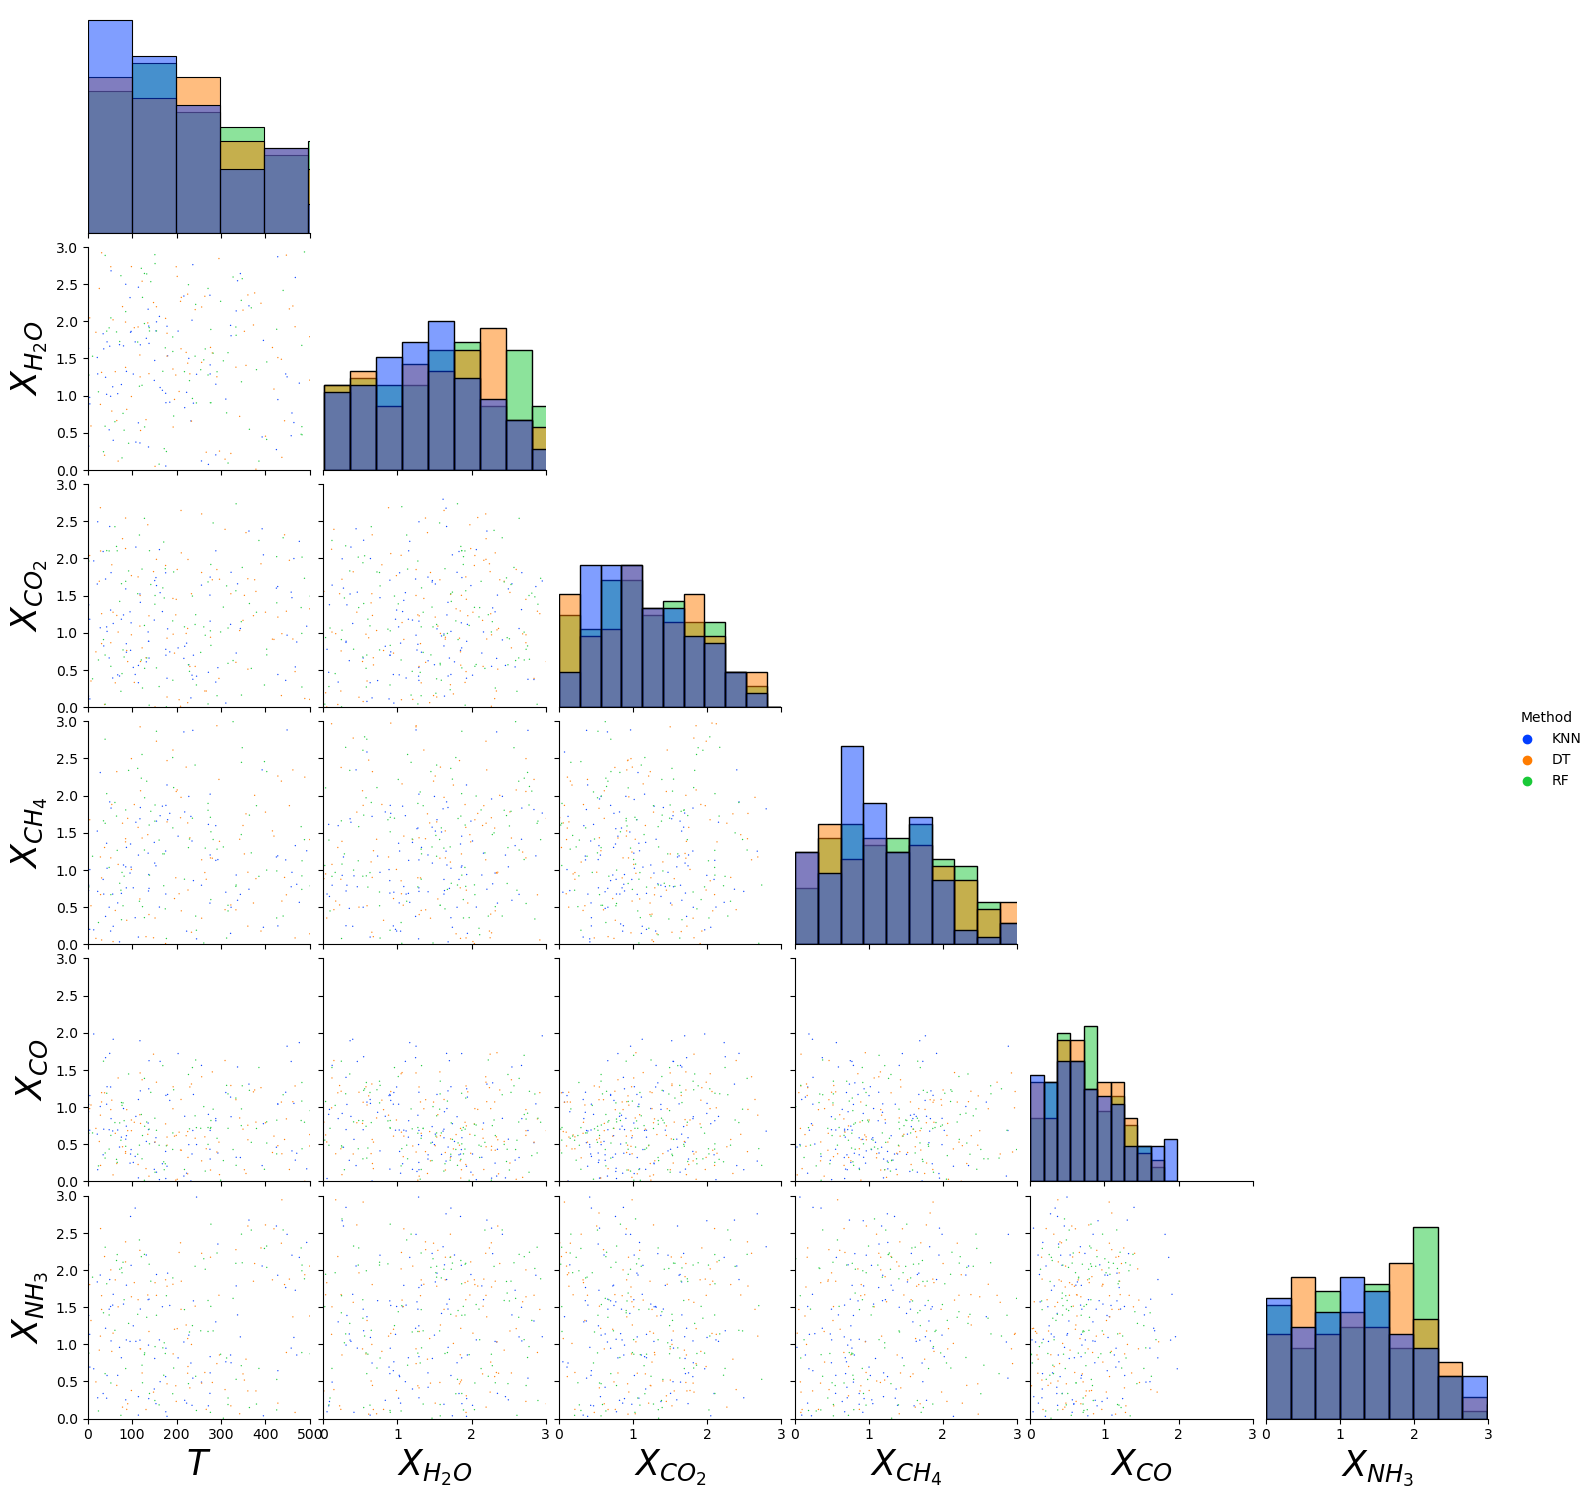

In [ ]:
plot_corner_differences(y_true = true_test_targets,
                        methods_results = [predictions_knn, predictions_dt, predictions_rf],
                        methods = ['KNN','DT','RF'],
                        y_keys = fm_keys)

# np.save(plots_path+'array_corner_differences_sl.npy',svr_trials)
# sns_plot.figure.savefig(plots_path+'corner_differences_sl_knn_dt_rf.png',bbox_inches='tight')

## Correlation Matrices for Results

In [ ]:
method_string = 'KNN'
single_method_parameters = param_found_knn
ensemble_regressors_list = None # Only for ensemble methods VOTE and STACK
ensemble_regressor_parameters_list = None # Only for ensemble methods VOTE and STACK
final_regressor_string = None  # Only for ensemble method STACK
single_final_regressor_parameters = None

trained_regressor_list_knn, predictions_knn, true_test_targets = supervised_training(x = x_train,
                                                                        y = y_train, 
                                                                        x_test = x_test,
                                                                        y_test = y_test,
                                                                        target_means = y_means,
                                                                        target_stds = y_stds,
                                                                        method = method_string,
                                                                        y_keys = fm_keys,
                                                                        method_parameters = single_method_parameters,
                                                                        ensemble_regressors = ensemble_regressors_list, # SVM, KNN, DT, RF (Voting), SVM, KNN, DT (Stacking) were used in the paper
                                                                        ensemble_regressor_parameters = ensemble_regressor_parameters_list ,
                                                                        final_regressor = final_regressor_string, # RF (Stacking only) were used in the paper
                                                                        final_regressor_parameters = single_final_regressor_parameters,
                                                                        target_transform = 'standardize',
                                                                        target_ppm_concentrations = target_ppm_concentrations
                                                                        )

method_string = 'DT'
single_method_parameters = param_found_dtr
ensemble_regressors_list = None # Only for ensemble methods VOTE and STACK
ensemble_regressor_parameters_list = None # Only for ensemble methods VOTE and STACK
final_regressor_string = None  # Only for ensemble method STACK
single_final_regressor_parameters = None

trained_regressor_list_dt, predictions_dt, true_test_targets = supervised_training(x = x_train,
                                                                        y = y_train, 
                                                                        x_test = x_test,
                                                                        y_test = y_test,
                                                                        target_means = y_means,
                                                                        target_stds = y_stds,
                                                                        method = method_string,
                                                                        y_keys = fm_keys,
                                                                        method_parameters = single_method_parameters,
                                                                        ensemble_regressors = ensemble_regressors_list, # SVM, KNN, DT, RF (Voting), SVM, KNN, DT (Stacking) were used in the paper
                                                                        ensemble_regressor_parameters = ensemble_regressor_parameters_list ,
                                                                        final_regressor = final_regressor_string, # RF (Stacking only) were used in the paper
                                                                        final_regressor_parameters = single_final_regressor_parameters,
                                                                        target_transform = 'standardize',
                                                                        target_ppm_concentrations = target_ppm_concentrations
                                                                        )

Choose a correlation matrix type: 
- 'values'
- 'bias'
- 'variance'

Plot the correlations matrix between the predicted and true target values for different methods

In [ ]:
method1_string = '$KNN, \mathcal{SL}$'

plot_corr_results(y_true = true_test_targets,
                      y_pred_method1 = predictions_knn,
                      method1 = method1_string,
                      y_keys = fm_keys,
                      y_pred_method2 = None, # only applicable for 'bias' or 'variance' type
                      method2 = None, #
                      matrix_type = 'values')

# plt.savefig(plots_path+'corr_sl_knn.png',bbox_inches='tight')

In [ ]:
method2_string = '$DT, \mathcal{SL}$'

plot_corr_results(y_true = true_test_targets,
                      y_pred_method1 = predictions_dt,
                      method1 = method2_string,
                      y_keys = fm_keys,
                      y_pred_method2 = None, # only applicable for 'bias' or 'variance' type
                      method2 = None, #
                      matrix_type = 'values')

# plt.savefig(plots_path+'corr_sl_dt.png',bbox_inches='tight')

Plot the correlation matrix for the model biases between two different models

In [ ]:
plot_corr_results(y_true = true_test_targets,
                      y_pred_method1 = predictions_knn,
                      method1 = method1_string,
                      y_keys = fm_keys,
                      y_pred_method2 = predictions_dt,
                      method2 = method2_string,
                      matrix_type = 'bias')

# plt.savefig(plots_path+'corr_sl_bias_knn_dt.png',bbox_inches='tight')

Plot the correlation matrix for the model variances between two different models

In [ ]:
plot_corr_results(y_true = true_test_targets,
                      y_pred_method1 = predictions_knn,
                      method1 = method1_string,
                      y_keys = fm_keys,
                      y_pred_method2 = predictions_dt,
                      method2 = method2_string,
                      matrix_type = 'variance')

# plt.savefig(plots_path+'corr_sl_variance_knn_dt.png',bbox_inches='tight')